# Chapter 3
## UK Min Temp

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import sys

from ch3.uk_temperature_prediction.raw_time_series import raw_time_series

import torch
import torch.nn.functional as F


## Data

In [2]:
def raw_time_series(__file__):
    dir_path = os.path.dirname(os.path.realpath(__file__))
    ts_df = pd.read_csv(f'{dir_path}/data/MET_Office_Weather_Data.csv')
    ts = ts_df.loc[ts_df['station'] == 'sheffield']['tmin']
    return ts

In [3]:
ts_df = raw_time_series('/project/docker/pytorch_dev/time_series_book/ch3/uk_temperature_prediction/data/')
print (type(ts_df))

<class 'pandas.core.series.Series'>


## Analyze

In [4]:
ts = ts_df.tolist()

In [5]:
print (f'row count: {len(ts)}')
print (f'Max: {np.nanmax(ts)}')
print (f'Min: {np.nanmin(ts)}')
print (f'Avg: {round(np.nanmean(ts),2)}')
print (f'Median: {round(np.nanmedian(ts),2)}')
print (f'Std: {round(np.nanstd(ts), 2)}')
print (f'NA values: {np.count_nonzero(np.isnan(ts))}')


row count: 1650
Max: 14.5
Min: -4.2
Avg: 6.22
Median: 5.7
Std: 4.04
NA values: 27


## Sliding Window Function

In [6]:
def sliding_window(ts, features):
    '''
    ts = time series list
    features = size of sliding window
    '''
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y

In [7]:
## test the function

ts = list(range(6))
X, Y = sliding_window(ts, 3)

print(f'Time series: {ts}')
print(f'X: {X}')
print(f'Y: {Y}')

Time series: [0, 1, 2, 3, 4, 5]
X: [[0, 1, 2], [1, 2, 3], [2, 3, 4]]
Y: [[3], [4], [5]]


## Pre-Process

In [8]:
# ts must be a panda dataframe
#  to use these methods
def interpolated_time_series(ts_df):
    ts_list = ts_df.interpolate().dropna().tolist()
    return ts_list

In [9]:
interp_ts_list = interpolated_time_series(ts_df)
print (type(interp_ts_list))

<class 'list'>


<function matplotlib.pyplot.show(close=None, block=None)>

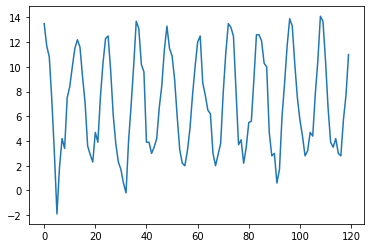

In [10]:
plt.plot(interp_ts_list[-120:])
plt.show

In [11]:
def get_training_datasets(ts_df, features, test_len):
    '''
    ts_df = time series dataframe
    features = sliding window size
    test_len = 
    '''
    ts = interpolated_time_series(ts_df)
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len], \
                                       Y[0:-test_len], \
                                       X[-test_len:], \
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)

    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)

    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test

## Architecture

### Layer 1 - convolution
### Layer 2 - decision making

### Hyperparameters:

- n_inp: num of features, or length of sliding window
- conv1_out: output channels in conv layer 1
- conv1_kernel: kernel of conv layer 1
- conv2_kernel: kernel of conv layer 2
- drop1: probability of dropout layer
- l_1: output for layer 1
- l_2: output for layer 2

In [12]:
class DL(torch.nn.Module):
    def __init__(self, n_inp, l_1, l_2, conv1_out, conv1_kernel, conv2_kernel, drop1 = 0, n_out = 1):
        super(DL, self).__init__()
        conv1_out_ch = conv1_out
        conv2_out_ch = conv1_out * 2
        
        conv1_kernel = conv1_kernel
        conv2_kernel = conv2_kernel
        
        self.dropout_lin1 = drop1
        self.pool = torch.nn.MaxPool1d(kernel_size = 2)
        self.conv1 = torch.nn.Conv1d(in_channels = 1, out_channels = conv1_out_ch, 
                        kernel_size = conv1_kernel, padding = conv1_kernel - 1)
        self.conv2 = torch.nn.Conv1d(in_channels = conv1_out_ch, out_channels = conv2_out_ch,
                        kernel_size = conv2_kernel, padding = conv2_kernel - 1)
        feature_tensor = self.feature_stack(torch.Tensor([[0] * n_inp]))
        self.lin1 = torch.nn.Linear(feature_tensor.size()[1], l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2, n_out)
    
    def feature_stack(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim = 1)
        return x
    
    def fc_stack(self, x):
        x1 = F.dropout(F.relu(self.lin1(x)), p = self.dropout_lin1)
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y
    
    def forward(self, x):
        x = self.feature_stack(x)
        y = self.fc_stack(x)
        return y

## Alternatives

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
class SarimaxPredictor(torch.nn.Module):
    def forward(self, x):
        last_values = []
        l = x.tolist()
        
        counter = 0
        
        for r in l:
            model = SARIMAX(r,
                order = (1,1,1),
                seasonal_order = (1,1,1,12)
                )
            results = model.fit(disp = 0)
            forecast = results.forecast()
            last_values.append([forecast[0]])
            counter = counter + 1
            print (f'debug: SARIMA calculation {counter} / {len(l)}')
            return torch.tensor(data = last_values)

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [16]:
class HwesPredictor(torch.nn.Module):
    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r,
                trend = None,
                seasonal = "add",
                seasonal_periods = 12
                )
            results = model.fit()
            forecast = results.forecast()
            last_values.append([forecast[0]])
        
        return torch.tensor(data = last_values)

# Full Example

In [17]:
random.seed(1)
torch.manual_seed(1)

In [18]:
features = 120   # 10 year observation

In [19]:
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(ts_df, features, 60)

## Initialing Models

In [20]:
# hyperparameter values
net = DL(
    n_inp = 120,
    l_1 = 400,
    l_2 = 48,
    conv1_out = 6,
    conv1_kernel = 36,
    conv2_kernel = 12,
    drop1 = 0.1
)
net.train()

DL(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 6, kernel_size=(36,), stride=(1,), padding=(35,))
  (conv2): Conv1d(6, 12, kernel_size=(12,), stride=(1,), padding=(11,))
  (lin1): Linear(in_features=528, out_features=400, bias=True)
  (lin2): Linear(in_features=400, out_features=48, bias=True)
  (lin3): Linear(in_features=48, out_features=1, bias=True)
)

In [21]:
sarima_predictor = SarimaxPredictor()

In [22]:
hwes_predictor = HwesPredictor()

## Loss & Optimization

In [23]:
optimizer = torch.optim.Adam(params = net.parameters())
abs_loss = torch.nn.L1Loss()

## Training

In [24]:
best_model = None
min_val_loss = sys.maxsize
training_loss = []
validation_loss = []

In [26]:
for t in range(150):
    prediction = net(x_train)
    
    loss = abs_loss(prediction, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    val_prediction = net(x_val)
    val_loss = abs_loss(val_prediction, y_val)
    
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()
        
    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)} '
              f'val: - {round(val_loss.item(), 4)}')
              

epoch 0: train - 5.6036 val: - 5.4287
epoch 10: train - 2.3853 val: - 2.3218
epoch 20: train - 1.3021 val: - 1.329
epoch 30: train - 1.0357 val: - 0.9396
epoch 40: train - 1.0206 val: - 1.0119
epoch 50: train - 1.0113 val: - 0.9639
epoch 60: train - 1.0 val: - 0.9783
epoch 70: train - 0.9933 val: - 0.9998
epoch 80: train - 0.9849 val: - 0.9605
epoch 90: train - 0.9679 val: - 0.9873
epoch 100: train - 0.9638 val: - 1.0061
epoch 110: train - 0.966 val: - 1.0034
epoch 120: train - 0.9574 val: - 0.9838
epoch 130: train - 0.9412 val: - 0.9749
epoch 140: train - 0.9264 val: - 0.9949


## Evaluation using test data

In [33]:
net.eval()
dl_prediction= best_model(x_test)
dl_abs_loss = round(abs_loss(dl_prediction, y_test).item(), 4)               

In [34]:
sarima_prediction = sarima_predictor(x_test)
sarima_abs_loss = round(abs_loss(sarima_prediction, y_test).item(), 4)

debug: SARIMA calculation 1 / 60


/home/jay/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([60, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [35]:
hwes_prediction = hwes_predictor(x_test)
hwes_abs_loss = round(abs_loss(hwes_prediction, y_test).item(), 4)

In [37]:
print (f'DL Loss: {dl_abs_loss}')
print (f'SARIMA Loss: {sarima_abs_loss}')
print (f'HWES Loss {hwes_abs_loss}')

DL Loss: 0.8651
SARIMA Loss: 5.4629
HWES Loss 1.0405


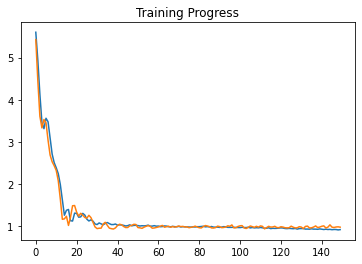

In [38]:
plt.title("Training Progress")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend
plt.show()

# Visualize the Graph

In [54]:
from torchviz import make_dot
import matplotlib.image as mpimg

In [55]:
yhat = net(x_train)

In [56]:
param_dict = dict(list(net.named_parameters()))

In [57]:
make_dot(yhat, params=param_dict).render("ch3_example_torchviz", format="png")
img = mpimg.imread('ch3_example_torchviz.png')

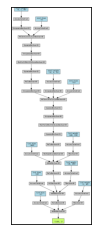

In [58]:
plt.xticks([])
plt.yticks([])
plt.imshow(img)